# Protocol definition

In [1]:
# %load STMprotocol.py
import serial
import struct
import datetime
import time

class STMprotocol:
    def __init__(self, serial_port):
        self.ser = serial.Serial(serial_port, 115200, timeout=0.2)
        self.pack_format = {
            0x01: "=BBBB",
            0x03: "=Bf",
            0x04: "=B",
            0x05: "=B",
            0x06: "=Bffff",
            0x07: "=B",
            0x08: "=fff",
            0x09: "=",
            0x0a: "=",
            0x0b: "=BH",
            0x0c: "=B",
            0x0d: "=B",
            
            0xa0: "=fff",
            0xa1: "=fff",
        }

        self.unpack_format = {
            0x01: "=BBBB",
            0x03: "=BB",
            0x04: "=BB",
            0x05: "=BB",
            0x06: "=BB",
            0x07: "=ffff",
            0x08: "=BB",
            0x09: "=fff",
            0x0a: "=fff",
            0x0b: "=BB",
            0x0c: "=f",
            0x0d: "=BB",
            
            0xa0: "=Bfff",
            0xa1: "=BB",
        }

    def send_command(self, cmd, args):
        # Clear buffer
        print(self.ser.read(self.ser.in_waiting))
        
        parameters = bytearray(struct.pack(self.pack_format[cmd], *args))
        print(parameters)
        msg_len = len(parameters) + 5
        msg = bytearray([0xfa, 0xaf, msg_len, cmd]) + parameters
        crc = sum(msg) % 256
        msg += bytearray([crc])

        print("send ", repr(msg))
        self.ser.write(msg)

        start_time = datetime.datetime.now()
        time_threshold = datetime.timedelta(seconds=1)
        dt = start_time - start_time
        
        time.sleep(0.001)
        data = self.ser.read()[0]
        while (data != 0xfa) and (dt < time_threshold):
            data = self.ser.read()[0]

            current_time = datetime.datetime.now()
            dt = start_time - current_time

        adr = self.ser.read()[0]
        answer_len = self.ser.read()[0]
        answer = bytearray(self.ser.read(answer_len - 3))
        print("answer ", repr(bytearray([data, adr, answer_len]) + answer))

        args = struct.unpack(self.unpack_format[cmd], answer[1:-1])
        return args


# Function of animation of output data

In [2]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
class Output_ploter(object):
    def __init__(self):
        self.xdata = []
        self.ydata = []
    def time_plot(self, protocol, cmd, args, param, time_duration=10):
        def generate_data():
            while(1): 
                res = protocol.send_command(cmd, args)
                yield res

        fig, ax = plt.subplots()
        ln, = ax.plot([])
        start_time = time.time()
        def init():
            ax.set_xlim(0, time_duration)
            return ln, 

        def update(frame):
            self.xdata.append(time.time() - start_time)
            self.ydata.append(frame[param])
            ln.set_data(self.xdata, self.ydata)
            if time_duration < self.xdata[-1]:
                ax.set_xlim(self.xdata[-1] - time_duration, self.xdata[-1])
            ax.set_ylim(min(self.ydata), max(self.ydata))
            return ln, 
        ani = FuncAnimation(fig, update, frames=generate_data(),
                        init_func=init, blit=True, interval=25)
        return ani
    def xy_plot(self, protocol, cmd, args, params, time_duration=10):
        def generate_data():
            while(1): 
                res = protocol.send_command(cmd, args)
                yield res

        fig, ax = plt.subplots()
        ln, = ax.plot([])
        start_time = time.time()
        def init():
            ax.set_xlim(0, time_duration)
            return ln, 

        def update(frame):
            self.xdata.append(frame[params[0]])
            self.ydata.append(frame[params[1]])
            ln.set_data(self.xdata, self.ydata)
            ax.set_xlim(min(self.xdata), max(self.xdata))
            ax.set_ylim(min(self.ydata), max(self.ydata))
            return ln, 
        ani = FuncAnimation(fig, update, frames=generate_data(),
                        init_func=init, blit=True, interval=25)
        return ani

# Work with STM

## Start protocol

In [47]:
protocol = STMprotocol("COM10")

In [46]:
protocol.ser.close()

## Test echo

In [48]:
# Echo
protocol.send_command(0x01, [ord(c) for c in 'ECHO'])

b''
bytearray(b'ECHO')
send  bytearray(b'\xfa\xaf\t\x01ECHO\xd2')
answer  bytearray(b'\xfa\xfa\t\x01ECHO\x1d')


(69, 67, 72, 79)

## On-line plotting of output data

<IPython.core.display.Javascript object>


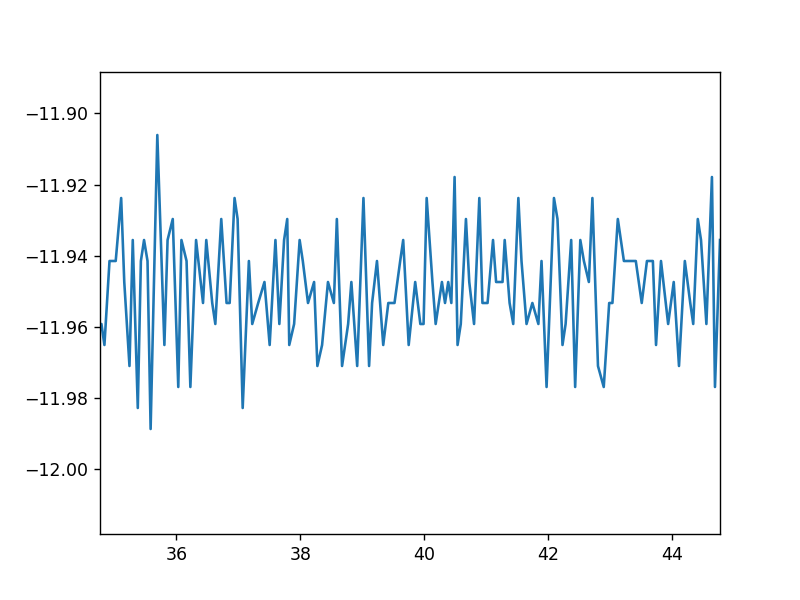

In [51]:
ploter = Output_ploter()
ani = ploter.plot(protocol, 0x07, [4], 3, 10)

In [45]:
print(ploter.xdata)

[0.20304346084594727, 0.277057409286499, 0.3410665988922119, 0.35806870460510254, 0.4060704708099365, 0.4606771469116211, 0.5196771621704102, 0.5296766757965088, 0.5862014293670654, 0.6492025852203369, 0.7072100639343262, 0.7772276401519775, 0.8322253227233887, 0.8892457485198975, 0.9427549839019775, 0.9532525539398193, 0.9992587566375732, 1.065274715423584, 1.0792698860168457, 1.1262784004211426, 1.181286334991455, 1.2387940883636475, 1.2532930374145508, 1.3032987117767334, 1.3683133125305176, 1.4253103733062744, 1.4843354225158691, 1.5033411979675293, 1.5483429431915283, 1.6053509712219238, 1.6283509731292725, 1.6803691387176514, 1.7363710403442383, 1.7543919086456299, 1.802391767501831, 1.859407663345337, 1.9164068698883057, 1.9754154682159424, 2.035412549972534, 2.101430892944336, 2.1554648876190186, 2.212465286254883, 2.270475149154663, 2.281472682952881, 2.334472894668579, 2.387493371963501, 2.4054927825927734, 2.4545059204101562, 2.509507179260254, 2.566027879714966, 2.580028772

In [44]:
# Set duty cycle of particular PWM channel
channel = 1
dutyCycle = 0.1
protocol.send_command(0x03, [channel, dutyCycle])

b''
bytearray(b'\x01\xcd\xcc\xcc=')
send  bytearray(b'\xfa\xaf\n\x03\x01\xcd\xcc\xcc=Y')
answer  bytearray(b'\xfa\xfa\x07\x03OK\x98')


(79, 75)

In [14]:
protocol.send_command(0x09, [])

b''
bytearray(b'')
send  bytearray(b'\xfa\xaf\x05\t\xb7')
answer  bytearray(b'\xfa\xfa\x11\tp\x8e\xe7\xbc\xe6t\xe4<yc\xae?\xf2')


(-0.028266161680221558, 0.027887772768735886, 1.3624106645584106)

b''
bytearray(b'')
send  bytearray(b'\xfa\xaf\x05\t\xb7')


In [ ]:
# Set direction bit for particular motor
channel = 1
protocol.send_command(0x04, [channel])

In [ ]:
# Reset direction bit for particular motor
channel = 1
protocol.send_command(0x05, [channel]);

In [52]:
# Set speed of all motors to 0

protocol.send_command(0x06, [4, 0, 0, 0, 0])

b''
bytearray(b'\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')
send  bytearray(b'\xfa\xaf\x16\x06\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc9')
answer  bytearray(b'\xfa\xfa\x07\x06OK\x9b')


(79, 75)

In [50]:
# Set speed of all motors in rad/s

protocol.send_command(0x06, [4, 0, 0, 0, 12])

b''
bytearray(b'\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@A')
send  bytearray(b'\xfa\xaf\x16\x06\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@AJ')
answer  bytearray(b'\xfa\xfa\x07\x06OK\x9b')


(79, 75)

In [ ]:
# Read speed of all wheels in rad/s
numberOfmotors = 4
protocol.send_command(0x07, [numberOfmotors])

In [8]:
# Set robot speed in its own coordinate system
Vx = 0.0
Vy = 0.0
Wz = 3.1415
protocol.send_command(0x08, [Vx, Vy, Wz])

b''
bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00V\x0e\xc9?')
send  bytearray(b'\xfa\xaf\x11\x08\x00\x00\x00\x00\x00\x00\x00\x00V\x0e\xc9?.')
answer  bytearray(b'\xfa\xfa\x07\x08OK\x9d')


(79, 75)

In [20]:
# Set robot speed in its own coordinate system
Vx = 0.0
Vy = 0.0
Wz = 0.0

protocol.send_command(0x08, [Vx, Vy, Wz])

b''
bytearray(b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00')
send  bytearray(b'\xfa\xaf\x11\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc2')
answer  bytearray(b'\xfa\xfa\x07\x08OK\x9d')


(79, 75)

In [ ]:
# Read robot speed in its own coordinate system
protocol.send_command(0x09, [])

In [ ]:
# Read robot coord in its own coordinate system
protocol.send_command(0x0a, [])

In [169]:
# Move servo of particular id (first parameter), to specified angle (second parameter) 
servoId = 2
angle = 255
protocol.send_command(0x0b, [servoId, angle])

b''
bytearray(b'\x02\xff\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x02\xff\x00\xbd')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')


(79, 75)

In [168]:
# Get angle of particular servo
servoId = 2
protocol.send_command(0x0c, [servoId])

b''
bytearray(b'\x02')
send  bytearray(b'\xfa\xaf\x06\x0c\x02\xbd')
answer  bytearray(b'\xfa\xfa\t\x0c\x00\x00\x00\x00\t')


(0.0,)

In [21]:
# Turn on/off forward kinematics calculations
status = 0
protocol.send_command(0x0D, [status])

b''
bytearray(b'\x00')
send  bytearray(b'\xfa\xaf\x06\r\x00\xbc')
answer  bytearray(b'\xfa\xfa\x07\rOK\xa2')


(79, 75)

In [ ]:
# Get status
protocol.send_command(0xa0, [1, 1, 1])

In [81]:
# Parameters for right manipulator
rightSliderId = 1
rightGripperId = 16

rightSliderUpPos = 45
rightSliderBotPos = 300
rightGripperOpened = 40
rightGripperClosed = 150

In [158]:
# Open and lower manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperOpened])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderBotPos])

b''
bytearray(b'\x10(\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x10(\x00\xf4')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')
b''
bytearray(b'\x01,\x01')
send  bytearray(b'\xfa\xaf\x08\x0b\x01,\x01\xea')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')


(79, 75)

In [159]:
# Close and lift manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperClosed])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderUpPos])

b''
bytearray(b'\x10\x96\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x10\x96\x00b')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')
b''
bytearray(b'\x01-\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x01-\x00\xea')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')


(79, 75)

In [160]:
# Open and lower manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperOpened])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderBotPos])

b''
bytearray(b'\x10(\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x10(\x00\xf4')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')
b''
bytearray(b'\x01,\x01')
send  bytearray(b'\xfa\xaf\x08\x0b\x01,\x01\xea')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')


(79, 75)

In [161]:
# Close and lift manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperClosed])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderUpPos])

b''
bytearray(b'\x10\x96\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x10\x96\x00b')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')
b''
bytearray(b'\x01-\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x01-\x00\xea')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')


(79, 75)

In [162]:
# Open and lower manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperOpened])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderBotPos])

b''
bytearray(b'\x10(\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x10(\x00\xf4')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')
b''
bytearray(b'\x01,\x01')
send  bytearray(b'\xfa\xaf\x08\x0b\x01,\x01\xea')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')


(79, 75)

In [167]:
# Close and lift manipulator
protocol.send_command(0x0b, [rightGripperId, rightGripperClosed])
time.sleep(0.5)
protocol.send_command(0x0b, [rightSliderId, rightSliderUpPos])

b''
bytearray(b'\x10\x96\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x10\x96\x00b')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')
b''
bytearray(b'\x01-\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x01-\x00\xea')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')


(79, 75)

In [166]:
# Lower and open
protocol.send_command(0x0b, [rightSliderId, rightSliderBotPos])
time.sleep(1)
protocol.send_command(0x0b, [rightGripperId, rightGripperOpened])

b''
bytearray(b'\x01,\x01')
send  bytearray(b'\xfa\xaf\x08\x0b\x01,\x01\xea')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')
b''
bytearray(b'\x10(\x00')
send  bytearray(b'\xfa\xaf\x08\x0b\x10(\x00\xf4')
answer  bytearray(b'\xfa\xfa\x07\x0bOK\xa0')


(79, 75)

In [ ]:
Vx = 0.0
Vy = 0.0
Wz = 3.1415926/2
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(3.3)

Vx = 0.0
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(0.3)

Vx = 0.0
Vy = 0.1
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(4)

Vx = 0.0
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(0.3)

Vx = 0.1
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(4)

Vx = 0.0
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(0.3)

Vx = -0.1
Vy = -0.1
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])

time.sleep(4)

Vx = 0.0
Vy = 0.0
Wz = 0.0
protocol.send_command(0x08, [Vx, Vy, Wz])